In [1]:
!pip install git+https://github.com/ChaoningZhang/MobileSAM.git
!pip install git+https://github.com/huggingface/peft.git
!pip install segmentation_models_pytorch scikit-image medpy


  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /tmp/pip-req-build-h5b3x7jv
  Running command git clone --filter=blob:none --quiet https://github.com/ChaoningZhang/MobileSAM.git /tmp/pip-req-build-h5b3x7jv
  Resolved https://github.com/ChaoningZhang/MobileSAM.git to commit 34bbbfdface3c18e5221aa7de6032d7220c6c6a1
  Preparing metadata (setup.py) ... done
  Created wheel for mobile_sam: filename=mobile_sam-1.0-py3-none-any.whl size=42431 sha256=97f0b24d260235ac36f64e64da3599b760ac4e6c1c245eb2e36b454ffc4d1126
  Stored in directory: /tmp/pip-ephem-wheel-cache-1_6qbpxv/wheels/5d/01/6d/a543d453fc9219c815786de44929ed1faa7bf6c8121e481cd7
Successfully built mobile_sam
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-kpv6xm1m
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-kpv6xm1m
  Resolved https://github.com/huggingface/peft.git to commit 4c82bfff76782fe62d7132373bbe2b2974068e7d
  Installing b

In [2]:
import os
import sys
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import KFold
from skimage.io import imread
from skimage.measure import label
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt as distance
from medpy.metric.binary import dc  # Dice
from tqdm import tqdm
import kagglehub
import glob
import cv2
import tifffile
from peft import LoraConfig, get_peft_model


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Download NuInsSeg dataset using KaggleHub
import kagglehub
import os
import glob

# Download and get base path
dataset_id = "ipateam/nuinsseg"
base_path = kagglehub.dataset_download(dataset_id)

# Function to get image and mask file paths
def collect_image_mask_paths(base_dir):
    image_paths = []
    mask_paths = []

    for organ in os.listdir(base_dir):
        tissue_dir = os.path.join(base_dir, organ, "tissue images")
        label_dir = os.path.join(base_dir, organ, "label masks")

        if not (os.path.isdir(tissue_dir) and os.path.isdir(label_dir)):
            continue

        images = sorted(glob.glob(os.path.join(tissue_dir, "*.png")))
        masks = sorted(glob.glob(os.path.join(label_dir, "*.tif")))

        if len(images) == len(masks):
            image_paths.extend(images)
            mask_paths.extend(masks)

    return image_paths, mask_paths

# Get image and mask paths
image_paths, mask_paths = collect_image_mask_paths(base_path)

# Display example pair and count
print("Sample image and mask pair:")
print("Image:", image_paths[0])
print("Mask :", mask_paths[0])
print(f"Total matched pairs: {len(image_paths)}")


Sample image and mask pair:
Image: /kaggle/input/nuinsseg/mouse muscle_tibia/tissue images/mouse_muscle_tibia_01.png
Mask : /kaggle/input/nuinsseg/mouse muscle_tibia/label masks/mouse_muscle_tibia_01.tif
Total matched pairs: 665


Displaying Image and Mask Pair...


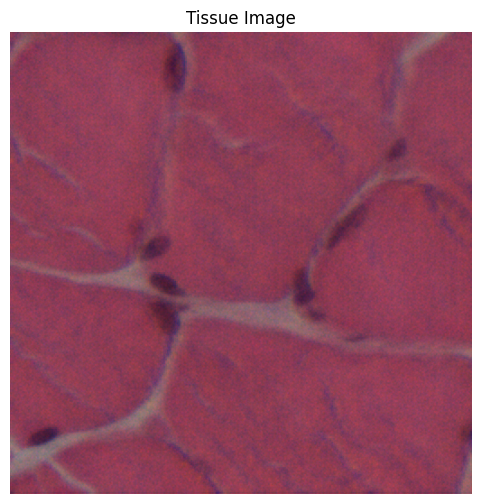

Mask shape: (512, 512)
Unique values in mask: [0 1 2 3 5]
Mask data type: uint16


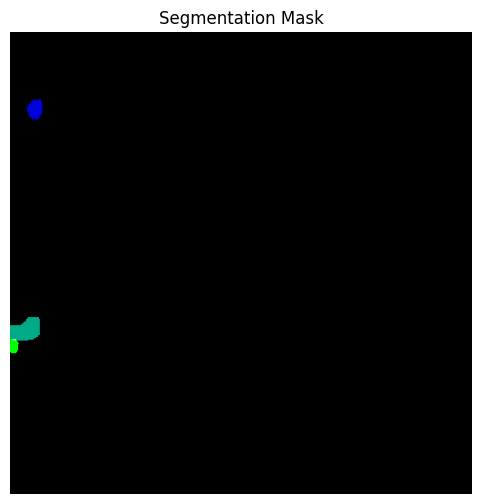

In [5]:
# Displaying an image and its corresponding mask
print("Displaying Image and Mask Pair...")

# Load and convert image
image = cv2.imread(image_paths[2])
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)
plt.title("Tissue Image")
plt.axis("off")
plt.show()

# Load and inspect mask
mask = tifffile.imread(mask_paths[5])
print(f"Mask shape: {mask.shape}")
print(f"Unique values in mask: {np.unique(mask)}")
print(f"Mask data type: {mask.dtype}")

# Plot the mask
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='nipy_spectral')
plt.title("Segmentation Mask")
plt.axis("off")
plt.show()


In [6]:

class NuInsSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, size=1024):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and process image
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.size, self.size))
        img = torch.tensor(img / 255.0, dtype=torch.float32).permute(2, 0, 1)

        # Load and process mask
        mask_path = self.mask_paths[idx]
        mask = tifffile.imread(mask_path)
        if mask is None:
            raise RuntimeError(f"Failed to load mask: {mask_path}")
        mask = cv2.resize(mask, (self.size, self.size), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0).astype(np.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask

# Instantiate dataset
dataset = NuInsSegDataset(image_paths, mask_paths)

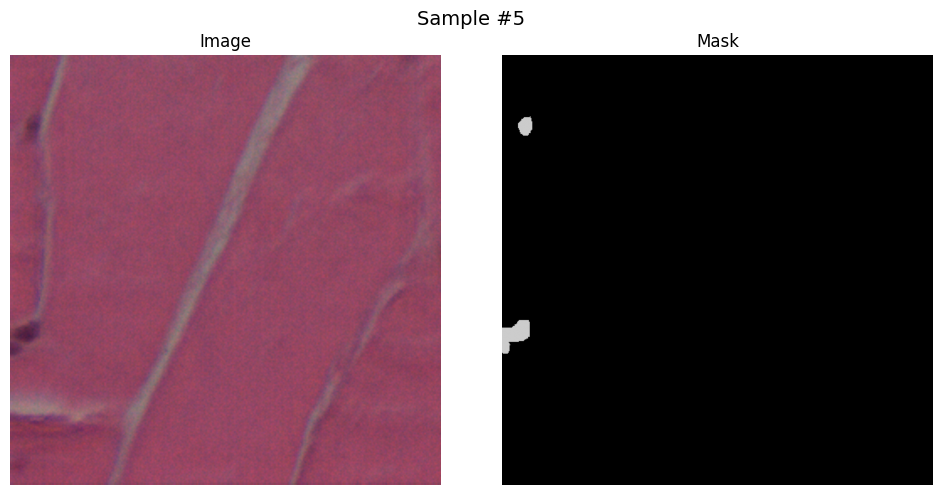

In [7]:
# Visualize a sample image and its mask
sample_img, sample_mask = dataset[5]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_img.permute(1, 2, 0))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask.squeeze(), cmap="nipy_spectral")
plt.title("Mask")
plt.axis("off")

plt.suptitle(f"Sample #{5}", fontsize=14)
plt.tight_layout()
plt.show()


In [8]:

class LoRALinear(nn.Module):
    def __init__(self, original_linear, r=4, alpha=1.0):
        super().__init__()

        # Freeze the original weights and bias
        self.weight = original_linear.weight
        self.bias = original_linear.bias
        self.weight.requires_grad = False
        if self.bias is not None:
            self.bias.requires_grad = False

        # LoRA parameters
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r

        self.A = nn.Parameter(torch.randn(r, original_linear.in_features) * 0.01)
        self.B = nn.Parameter(torch.randn(original_linear.out_features, r) * 0.01)

    def forward(self, x):
        base_out = x @ self.weight.T
        if self.bias is not None:
            base_out += self.bias

        lora_out = (x @ self.A.T) @ self.B.T
        return base_out + self.scaling * lora_out

In [9]:
# Add MobileSAM to path
sys.path.append('/content/MobileSAM')
from mobile_sam import sam_model_registry

# Load checkpoint
checkpoint_path = "/content/mobile_sam.pt"
if not os.path.exists(checkpoint_path):
    !wget https://huggingface.co/ChaoningZhang/MobileSAM/resolve/main/mobile_sam.pt -O mobile_sam.pt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model = sam_model_registry["vit_t"](checkpoint=checkpoint_path).to(device)
sam_model.eval()

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.11/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m

Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

In [10]:
# Freeze all model parameters
for param in sam_model.parameters():
    param.requires_grad = False

# Recursively replace nn.Linear with LoRA-wrapped versions
def apply_lora_to_linears(module, device='cuda'):
    for module_name, sub_module in module.named_children():
        if isinstance(sub_module, nn.Linear):
            lora_linear = LoRALinear(sub_module).to(device)
            setattr(module, module_name, lora_linear)
        else:
            apply_lora_to_linears(sub_module, device)

# Apply LoRA to the image encoder of SAM
apply_lora_to_linears(sam_model.image_encoder, device=device)

# Unfreeze parameters in the mask decoder for training
for param in sam_model.mask_decoder.parameters():
    param.requires_grad = True

# Define optimizer using only trainable parameters
trainable_parameters = [param for param in sam_model.parameters() if param.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-4)

print("MobileSAM weights loaded and LoRA applied successfully.")


MobileSAM weights loaded and LoRA applied successfully.


In [11]:
# Count and report total and trainable parameters
total_params = sum(param.numel() for param in sam_model.parameters())
trainable_params = sum(param.numel() for param in sam_model.parameters() if param.requires_grad)

# Print out the counts and percentage of trainable parameters
print(f"Total Parameters        : {total_params:,}")
print(f"Trainable Parameters    : {trainable_params:,}")
print(f"Tunable Parameters in Percent    : {100 * trainable_params / total_params:.4f}%")


Total Parameters        : 10,254,156
Trainable Parameters    : 4,182,404
Tunable Parameters in Percent    : 40.7874%


In [12]:
# ## Dice Coefficient Method
# def Dice_Coefficient(pred, target, smooth=1e-6):
#     pred = pred.contiguous().view(-1)
#     target = target.contiguous().view(-1)
#     intersection = (pred * target).sum()
#     return (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)


# ## AJI Score Method
# def Aji_Score(gt, pred):
#     from skimage.measure import label, regionprops
#     gt = label(gt)
#     pred = label(pred)
#     used = set()
#     inter_sum = 0
#     union_sum = 0

#     for g in regionprops(gt):
#         best_iou, best_p = 0, None
#         for p in regionprops(pred):
#             if p.label in used:
#                 continue
#             gi = (gt == g.label)
#             pi = (pred == p.label)
#             intersection = np.logical_and(gi, pi).sum()
#             union = np.logical_or(gi, pi).sum()
#             iou = intersection / (union + 1e-6)
#             if iou > best_iou:
#                 best_iou = iou
#                 best_p = p.label
#         if best_p is not None:
#             used.add(best_p)
#             gi = (gt == g.label)
#             pi = (pred == best_p)
#             inter_sum += np.logical_and(gi, pi).sum()
#             union_sum += np.logical_or(gi, pi).sum()

#     for p in regionprops(pred):
#         if p.label not in used:
#             union_sum += (pred == p.label).sum()

#     return inter_sum / (union_sum + 1e-6)


# ## Fast PQ Score Method
# def Fast_PQ(true, pred, match_iou=0.5):
#     true = np.copy(true)
#     pred = np.copy(pred)
#     true_id_list = list(np.unique(true))
#     pred_id_list = list(np.unique(pred))

#     # Return early if only background is present
#     if len(pred_id_list) == 1:
#         return [0, 0, 0], [0, 0, 0, 0]

#     # Generate masks for each true and predicted instance
#     true_masks = [None]  # Ignore background
#     for t in true_id_list[1:]:
#         t_mask = np.array(true == t, np.uint8)
#         true_masks.append(t_mask)

#     pred_masks = [None]  # Ignore background
#     for p in pred_id_list[1:]:
#         p_mask = np.array(pred == p, np.uint8)
#         pred_masks.append(p_mask)

#     # Pairwise IoU matrix initialized with zeros
#     pairwise_iou_matrix = np.zeros([len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64)

#     # Compute pairwise IoU
#     for true_id in true_id_list[1:]:  # Skip background
#         t_mask = true_masks[true_id]
#         pred_true_overlap = pred[t_mask > 0]
#         pred_true_overlap_id = np.unique(pred_true_overlap)
#         for pred_id in pred_true_overlap_id:
#             if pred_id == 0:  # Ignore background
#                 continue
#             p_mask = pred_masks[pred_id]
#             total = (t_mask + p_mask).sum()
#             intersection = (t_mask * p_mask).sum()
#             iou = intersection / (total - intersection)
#             pairwise_iou_matrix[true_id - 1, pred_id - 1] = iou

#     # Handle IoU thresholding for pairing
#     if match_iou >= 0.5:
#         paired_iou = pairwise_iou_matrix[pairwise_iou_matrix > match_iou]
#         pairwise_iou_matrix[pairwise_iou_matrix <= match_iou] = 0.0
#         paired_true, paired_pred = np.nonzero(pairwise_iou_matrix)
#         paired_iou = pairwise_iou_matrix[paired_true, paired_pred]
#         paired_true += 1  # Adjust for 1-based IDs
#         paired_pred += 1
#     else:
#         # Use Munkres (Hungarian algorithm) for optimal pairing
#         paired_true, paired_pred = linear_sum_assignment(-pairwise_iou_matrix)
#         paired_iou = pairwise_iou_matrix[paired_true, paired_pred]
#         paired_true = list(paired_true[paired_iou > match_iou] + 1)
#         paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
#         paired_iou = paired_iou[paired_iou > match_iou]

#     # Find unpaired instances
#     unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
#     unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]

#     # Compute TP, FP, FN, DQ, SQ
#     tp = len(paired_true)
#     fp = len(unpaired_pred)
#     fn = len(unpaired_true)

#     dq = tp / (tp + 0.5 * fp + 0.5 * fn)  # DQ
#     sq = paired_iou.sum() / (tp + 1e-6)  # SQ
#     pq = dq * sq  # PQ

#     return [dq, sq, pq], [paired_true, paired_pred, unpaired_true, unpaired_pred]


In [13]:
import torch.nn.functional as F

# Initialize KFold
kf_fold = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf_fold.split(dataset))

# Lists to store the evaluation metrics for each fold
all_dice, all_aji, all_pq = [], [], []

# Loop over each fold
for fold, (train_idx, test_idx) in enumerate(folds):
    print(f"\nRunning Fold ---> {fold+1}/5")

    # Create DataLoader for train and test sets
    train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=16, shuffle=True)
    test_loader  = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=8)

    # Training Loop
    for epoch in range(2):
        sam_model.train()  # Set the model to training mode
        total_loss = 0  # Initialize total loss for the epoch

        # Iterate through training batches
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            imgs, masks = imgs.to(device), masks.to(device)  # Move data to the device

            # Forward pass (no gradient tracking for some steps)
            with torch.no_grad():
                emb = sam_model.image_encoder(imgs)  # Image embedding from encoder
            sparse, dense = sam_model.prompt_encoder(None, None, None)
            image_pe = sam_model.prompt_encoder.get_dense_pe()

            # Prediction (Mask decoder output)
            masks_pred, _ = sam_model.mask_decoder(emb, image_pe, sparse, dense, False)
            logits = masks_pred[:, 0]  # [B, H, W] Mask logits
            logits = F.interpolate(logits.unsqueeze(1), size=(1024, 1024), mode='bilinear', align_corners=False)

            # Loss calculation (Binary cross-entropy)
            loss = F.binary_cross_entropy_with_logits(logits, masks)

            # Backpropagation
            optimizer.zero_grad()  # Zero gradients from previous step
            loss.backward()        # Backpropagate the loss
            optimizer.step()       # Update weights

            total_loss += loss.item()  # Add loss for this batch to total loss

        # Print average loss for the epoch
        print(f"|| Epoch {epoch+1} Loss || {total_loss / len(train_loader):.4f}")


Running Fold ---> 1/5


Epoch 1: 100%|██████████| 34/34 [01:22<00:00,  2.42s/it]


|| Epoch 1 Loss || 0.3446


Epoch 2: 100%|██████████| 34/34 [01:08<00:00,  2.03s/it]


|| Epoch 2 Loss || 0.2492

Running Fold ---> 2/5


Epoch 1: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]


|| Epoch 1 Loss || 0.2508


Epoch 2: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 2 Loss || 0.2353

Running Fold ---> 3/5


Epoch 1: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]


|| Epoch 1 Loss || 0.2260


Epoch 2: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 2 Loss || 0.2249

Running Fold ---> 4/5


Epoch 1: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]


|| Epoch 1 Loss || 0.2266


Epoch 2: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 2 Loss || 0.2125

Running Fold ---> 5/5


Epoch 1: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 1 Loss || 0.2099


Epoch 2: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

|| Epoch 2 Loss || 0.2130


In [14]:
torch.save(sam_model.state_dict(), 'model_epochs.pth')



In [15]:
from google.colab import files
files.download('model_epochs.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
from skimage.measure import label
from skimage.segmentation import watershed, clear_border
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi
from skimage.filters import sobel

sam_model.eval()  # Set model to evaluation mode
dice_scores, aji_scores = [], []

# Loop over the test data
with torch.no_grad():
    for images, ground_truth_masks in test_loader:
        images, ground_truth_masks = images.to(device), ground_truth_masks.to(device)

        # Forward pass through the model
        embeddings = sam_model.image_encoder(images)
        sparse, dense = sam_model.prompt_encoder(None, None, None)
        image_pe = sam_model.prompt_encoder.get_dense_pe()
        predicted_masks, _ = sam_model.mask_decoder(embeddings, image_pe, sparse, dense, False)

        # Model prediction (Sigmoid and resizing)
        predicted = torch.sigmoid(predicted_masks[:, 0])
        predicted = nn.functional.interpolate(predicted.unsqueeze(1), size=(1024, 1024), mode='bilinear', align_corners=False)
        predicted_binary = (predicted > 0.3).float().cpu().numpy().squeeze().astype(np.uint8)
        ground_truth_binary = ground_truth_masks.cpu().numpy().squeeze().astype(np.uint8)

        # Post-processing to improve AJI score
        distance_transform = ndi.distance_transform_edt(predicted_binary)
        edges = sobel(predicted_binary)
        markers = label(predicted_binary)
        watershed_labels = watershed(-distance_transform, markers, mask=predicted_binary)

        # Clean up small objects and border regions
        watershed_labels = remove_small_objects(watershed_labels, min_size=30)
        watershed_labels = clear_border(watershed_labels)

        # Calculate metrics
        dice_scores.append(Dice_Coefficient(torch.tensor(predicted_binary), torch.tensor(ground_truth_binary)).item())
        aji_scores.append(Aji_Score(ground_truth_binary, watershed_labels))

# Calculate and print the average scores
mean_dice_score = np.mean(dice_scores)
mean_aji_score = np.mean(aji_scores)

print(f"\nPost-Processed 5-Fold Average Metrics")
print("=======================================")
print(f"Dice Score: {mean_dice_score:.4f}")
print(f"AJI Score : {mean_aji_score:.4f}")



Post-Processed 5-Fold Average Metrics
Dice Score: 0.6768
AJI Score : 0.1251


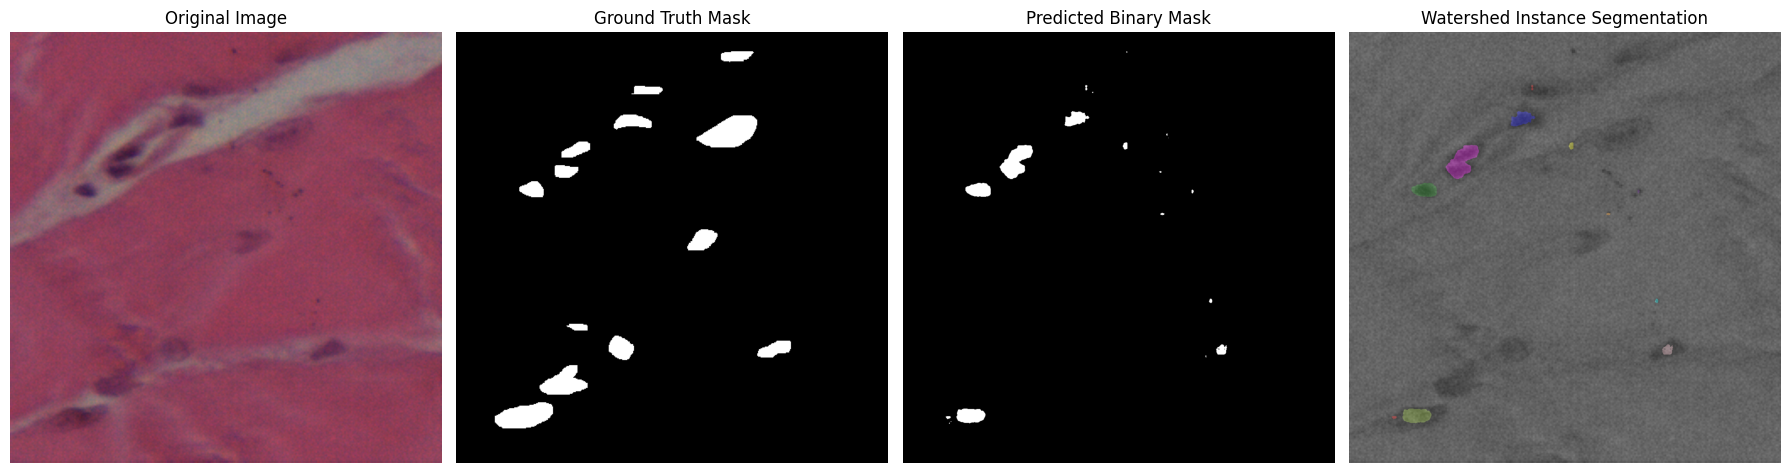

In [16]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import scipy.ndimage as ndi
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_objects, label
from skimage.segmentation import clear_border



def visualize_prediction(img_tensor, gt_mask, pred_bin, watershed_labels):
    img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
    gt_mask_np = gt_mask.cpu().squeeze().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(18, 5))
    axs[0].imshow(img_np)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(gt_mask_np, cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_bin, cmap='gray')
    axs[2].set_title("Predicted Binary Mask")
    axs[2].axis("off")

    axs[3].imshow(label2rgb(watershed_labels, image=img_np, bg_label=0))
    axs[3].set_title("Watershed Instance Segmentation")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()

# Inference and visualization
sam_model.eval()
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        emb = sam_model.image_encoder(imgs)
        sparse, dense = sam_model.prompt_encoder(None, None, None)
        image_pe = sam_model.prompt_encoder.get_dense_pe()
        masks_pred, _ = sam_model.mask_decoder(emb, image_pe, sparse, dense, False)

        pred = torch.sigmoid(masks_pred[:, 0])
        pred = nn.functional.interpolate(pred.unsqueeze(1), size=(1024, 1024), mode='bilinear', align_corners=False)
        pred_np = pred.cpu().numpy()
        gt_np = masks.cpu().numpy()

        for b in range(imgs.shape[0]):
            pred_bin = (pred_np[b, 0] > 0.3).astype(np.uint8)
            gt_bin = gt_np[b].astype(np.uint8)

            distance = ndi.distance_transform_edt(pred_bin)
            markers = label(pred_bin)
            labels = watershed(-distance, markers, mask=pred_bin)
            labels = remove_small_objects(labels, min_size=30)
            labels = clear_border(labels)

            # Visualize only first one
            visualize_prediction(imgs[b], masks[b], pred_bin, labels)
            break  # Remove this if you want to loop through more images

        break


In [37]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(dataset))

all_dice, all_aji, all_pq = [], [], []

for fold, (train_idx, test_idx) in enumerate(folds):
    print(f"\nRunning Fold ---> {fold + 1}/5")

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=16, shuffle=True)
    test_loader = DataLoader(Subset(dataset, test_idx), batch_size=8)

    for epoch in range(10):
        sam_model.train()
        total_loss = 0

        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            imgs, masks = imgs.to(device), masks.to(device)

            with torch.no_grad():
                emb = sam_model.image_encoder(imgs)

            sparse, dense = sam_model.prompt_encoder(None, None, None)
            image_pe = sam_model.prompt_encoder.get_dense_pe()

            masks_pred, _ = sam_model.mask_decoder(emb, image_pe, sparse, dense, False)
            logits = masks_pred[:, 0].unsqueeze(1)
            logits = F.interpolate(logits, size=(1024, 1024), mode='bilinear', align_corners=False)

            loss = F.binary_cross_entropy_with_logits(logits, masks)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item()

        print(f"|| Epoch {epoch + 1} Loss || {total_loss / len(train_loader):.4f}")

    # -------- Evaluation -------- #
    sam_model.eval()
    dice_scores, aji_scores, pq_scores = [], [], []

    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc="Evaluating"):
            imgs, masks = imgs.to(device), masks.to(device)
            emb = sam_model.image_encoder(imgs)
            sparse, dense = sam_model.prompt_encoder(None, None, None)
            image_pe = sam_model.prompt_encoder.get_dense_pe()
            masks_pred, _ = sam_model.mask_decoder(emb, image_pe, sparse, dense, False)

            for i in range(imgs.size(0)):
                pred = torch.sigmoid(masks_pred[i, 0]).unsqueeze(0).unsqueeze(0)
                pred = F.interpolate(pred, size=(1024, 1024), mode='bilinear', align_corners=False)
                pred_bin = (pred > 0.3).float().cpu().numpy().squeeze().astype(np.uint8)

                gt = F.interpolate(masks[i].unsqueeze(0), size=(1024, 1024), mode='nearest')
                gt_bin = gt.cpu().numpy().squeeze().astype(np.uint8)

                dice = Dice_Coefficient(torch.tensor(pred_bin), torch.tensor(gt_bin)).item()
                aji = Aji_Score(gt_bin, pred_bin)
                pq_result, _ = Fast_PQ(gt_bin, pred_bin)

                dice_scores.append(dice)
                aji_scores.append(aji)
                pq_scores.append(pq_result[2])

    print(f" ****************Fold Dice: {np.mean(dice_scores):.4f} | AJI: {np.mean(aji_scores):.4f} | PQ: {np.mean(pq_scores):.4f} *************")
    all_dice.append(np.mean(dice_scores))
    all_aji.append(np.mean(aji_scores))
    all_pq.append(np.mean(pq_scores))

# -------- Final Results -------- #
print("\n5-Fold Average Scores")
print("************************")
print(f"Average Dice Score Result: {np.mean(all_dice):.4f}")
print(f"Average AJI Score Result: {np.mean(all_aji):.4f}")
print(f"Average PQ Score Result: {np.mean(all_pq):.4f}")



Running Fold ---> 1/5


Epoch 1: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it]


|| Epoch 1 Loss || 0.1996


Epoch 2: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]


|| Epoch 2 Loss || 0.1924


Epoch 3: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 3 Loss || 0.1912


Epoch 4: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]


|| Epoch 4 Loss || 0.1893


Epoch 5: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 5 Loss || 0.1892


Epoch 6: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 6 Loss || 0.1862


Epoch 7: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 7 Loss || 0.1862


Epoch 8: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 8 Loss || 0.1861


Epoch 9: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 9 Loss || 0.1830


Epoch 10: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 10 Loss || 0.1797


Evaluating: 100%|██████████| 17/17 [16:06<00:00, 56.85s/it]


 ****************Fold Dice: 0.6158 | AJI: 0.3554 | PQ: 0.2978 *************

Running Fold ---> 2/5


Epoch 1: 100%|██████████| 34/34 [01:09<00:00,  2.03s/it]


|| Epoch 1 Loss || 0.1986


Epoch 2: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]


|| Epoch 2 Loss || 0.1939


Epoch 3: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 3 Loss || 0.1919


Epoch 4: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 4 Loss || 0.1899


Epoch 5: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 5 Loss || 0.1914


Epoch 6: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 6 Loss || 0.1910


Epoch 7: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 7 Loss || 0.1911


Epoch 8: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 8 Loss || 0.1863


Epoch 9: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 9 Loss || 0.1875


Epoch 10: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 10 Loss || 0.1874


Evaluating: 100%|██████████| 17/17 [12:08<00:00, 42.84s/it]


 ****************Fold Dice: 0.6669 | AJI: 0.4169 | PQ: 0.3851 *************

Running Fold ---> 3/5


Epoch 1: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]


|| Epoch 1 Loss || 0.1882


Epoch 2: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 2 Loss || 0.1854


Epoch 3: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]


|| Epoch 3 Loss || 0.1849


Epoch 4: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 4 Loss || 0.1819


Epoch 5: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 5 Loss || 0.1812


Epoch 6: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 6 Loss || 0.1835


Epoch 7: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 7 Loss || 0.1825


Epoch 8: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 8 Loss || 0.1844


Epoch 9: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 9 Loss || 0.1856


Epoch 10: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 10 Loss || 0.1872


Evaluating: 100%|██████████| 17/17 [13:50<00:00, 48.85s/it]


 ****************Fold Dice: 0.6692 | AJI: 0.4153 | PQ: 0.3971 *************

Running Fold ---> 4/5


Epoch 1: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]


|| Epoch 1 Loss || 0.1791


Epoch 2: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]


|| Epoch 2 Loss || 0.1790


Epoch 3: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 3 Loss || 0.1760


Epoch 4: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 4 Loss || 0.1760


Epoch 5: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 5 Loss || 0.1771


Epoch 6: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 6 Loss || 0.1743


Epoch 7: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]


|| Epoch 7 Loss || 0.1716


Epoch 8: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 8 Loss || 0.1738


Epoch 9: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 9 Loss || 0.1755


Epoch 10: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 10 Loss || 0.1728


Evaluating: 100%|██████████| 17/17 [12:57<00:00, 45.73s/it]


 ****************Fold Dice: 0.7212 | AJI: 0.4821 | PQ: 0.4691 *************

Running Fold ---> 5/5


Epoch 1: 100%|██████████| 34/34 [01:10<00:00,  2.09s/it]


|| Epoch 1 Loss || 0.1759


Epoch 2: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 2 Loss || 0.1769


Epoch 3: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 3 Loss || 0.1733


Epoch 4: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 4 Loss || 0.1729


Epoch 5: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 5 Loss || 0.1729


Epoch 6: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 6 Loss || 0.1701


Epoch 7: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 7 Loss || 0.1726


Epoch 8: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 8 Loss || 0.1696


Epoch 9: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]


|| Epoch 9 Loss || 0.1678


Epoch 10: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


|| Epoch 10 Loss || 0.1676


Evaluating: 100%|██████████| 17/17 [13:54<00:00, 49.11s/it]

 ****************Fold Dice: 0.6990 | AJI: 0.4451 | PQ: 0.4394 *************

5-Fold Average Scores
************************
Average Dice Score Result: 0.6744
Average AJI Score Result: 0.4230
Average PQ Score Result: 0.3977
